In [1]:
#faves
import pandas as pd
import math
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

#project specific
from scipy.optimize import fsolve
from scipy.stats import norm
from scipy.stats import uniform
from scipy.stats import rv_continuous

In [35]:
def create_costs(mean, var):
    """create a cost function using scipy norm"""
    costs = rv_continuous()
    costs.pdf = lambda x: norm.pdf(x, loc=mean,scale=var)
    costs.cdf = lambda x: norm.cdf(x, loc=mean,scale=var)
    costs.rv =  lambda x: norm.rvs(loc=mean, scale=var, size=x)
    return costs


def gen_sims(value, reserve, nsims, seed=123):
    """generate sims for monte carlo integration"""
    n = len(value)
    np.random.seed(seed) #seed the rng so results are reproducible
    v_tile = np.repeat(value - reserve, nsims)
    r_tile = np.tile(reserve, n*nsims)
    sims = uniform.rvs(loc=r_tile, scale=v_tile)
    return sims.reshape(n,nsims)


def calc_profits(value, i, cost, reserve, nsims=20):
    """calculate integral with surplus"""
    sims = gen_sims(value, reserve, nsims)
    profits = (value-reserve)*(cost.cdf(sims)**(i-1)).mean(axis=1)
    return profits


def calc_bid(value, i, cost, reserve, nsims=20):
    """calculate bids based on value and reserve price"""
    value = np.maximum(value, reserve)
    integral = calc_profits(value, i, cost, reserve, nsims=nsims)
    bids =  value - integral/(cost.cdf(value))**(i-1)
    return bids


def sim_auction(i, n, cost, reserve, nsims=20, seed=321):
    """simulate auction data"""
    np.random.seed(seed)
    values = cost.rvs(size=(i*n)) #clip rhs of distribution
    bids = calc_bid(values, i, cost, reserve, nsims=nsims)
    return values, bids


def calc_cutoff(max_v, i, cost, reserve, nsims=20):
    """calc mixture probabilities structurally"""
    profit = lambda vi: calc_profits(vi, i, cost, reserve, nsims=nsims)
    col_profit = profit(max_v)/( cost.cdf(max_v) )**(i-1)
    ic = lambda vi: profit(np.maximum(vi,reserve)) - col_profit
    value = fsolve(ic, max_v)
    return value


def sim_mix(max_v, i, n, cost, reserve, nsims=20, seed=321):
    """gen data for a mixture model"""
    #gen values
    np.random.seed(seed)
    values = cost.rvs(size=(i*n))
    
    #figure our states that we are not collusive
    cutoff = calc_cutoff(max_v, i, cost, reserve, nsims=nsims)
    state = values.reshape(i,n).max(axis=0) <= cutoff
    all_state = np.repeat(state,i)
    col_values = np.minimum(values, max_v)
    all_values = all_state*col_values + (1-all_state)*values
    
    bids = calc_bid(all_values, i, cost, reserve, nsims=nsims)
    return values, bids, state


COST = create_costs(1.8, .5)
data = sim_mix(np.array([2]), 7, 100, COST, 0, 1000)

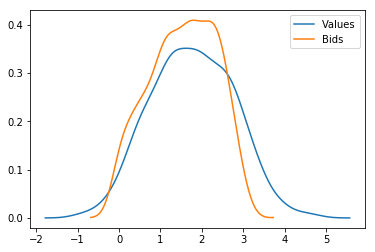

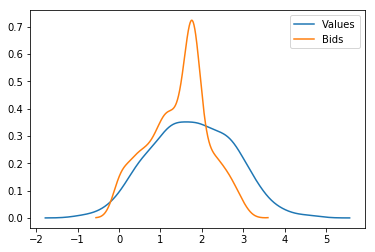

In [36]:
def graph_auction(i, n, cost,nsims=20):
    
    values, bids = sim_auction(i,n,cost, 0, nsims=nsims)
    
    v_dens = sm.nonparametric.KDEUnivariate(values)
    v_dens.fit()
    plt.plot(v_dens.support, v_dens.density, label='Values')
    
    b_dens = sm.nonparametric.KDEUnivariate(bids)
    b_dens.fit()
    plt.plot(b_dens.support, b_dens.density, label='Bids') #.cdf does cdf
    
    plt.legend()
    plt.show()

    
def graph_mix(max_v, i, n, cost, nsims=20):
    
    values, bids, state = sim_mix(max_v,i,n,cost, 0, nsims=nsims)
    v_dens = sm.nonparametric.KDEUnivariate(values)
    v_dens.fit()
    plt.plot(v_dens.support, v_dens.density, label='Values')
    
    b_dens = sm.nonparametric.KDEUnivariate(bids)
    b_dens.fit()
    plt.plot(b_dens.support, b_dens.density, label='Bids') #.cdf does cdf
    
    plt.legend()
    plt.show()
    
COST = create_costs(1.8,1)
data = graph_auction(7, 100, COST, 1000)
data = graph_mix(np.array([2]), 7, 100, COST, 1000)